In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

In [3]:
# Setting some dimensions
n = 100
m = 50
k = 10

In [4]:
# Generating a low rank matrix
A = np.random.uniform(size = (n,k))
S = np.random.uniform(size = (k,m))
X = np.dot(A,S)

In [5]:
# This function updates the decomposition for X
def updateNMF(X, A, S):
    A_new = A*np.dot(X,S.T)/(np.dot(A,np.dot(S,S.T)))
    S_new = S*np.dot(A.T,X)/np.dot(A.T,np.dot(A,S))
    return((A_new,S_new))

In [6]:
# Standard NMF via a multiplicative algorithm
def NMF(X,k):

    """
        NMF is implementing the standard Nonnegative Matrix Factorization
        using a multiplicative algorithm. 
        X = AxS
        
        Parameters:
        X - array-like, the matrix to be decomposed
        k - the low rank
    
        Returns:
        A - array like (decomposition of X)
        S - array lile (decomposition of X)
        err - an array storing the error
    
    """
    
    # Set the dimensions
    n = X.shape[0]
    m = X.shape[1]
    
    # Initialize A and S
    A = np.random.uniform(size = (n,k))
    S = np.random.uniform(size = (k,m))

    # Iterate
    nofIt = 100
    err = np.zeros((100,))
    
    for it in range(nofIt):
        A,S = updateNMF(X,A,S)
        err[it] = np.sum((X - np.dot(A,S))**2)
        
    return(A,S,err)

In [7]:
A_hat, S_hat, err_hat = NMF(X,10)

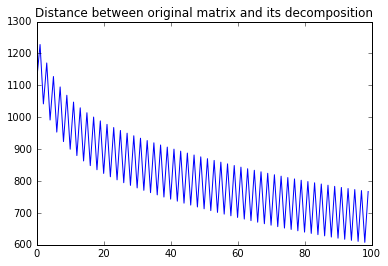

In [8]:
plt.plot(err_hat)
err_hat.shape
plt.title('Distance between original matrix and its decomposition')

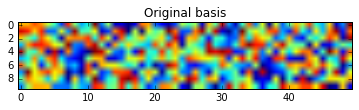

In [9]:
plt.imshow(S)
plt.title('Original basis')

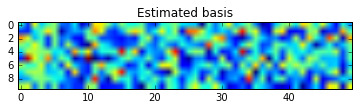

In [10]:
plt.imshow(S_hat)
plt.title('Estimated basis')

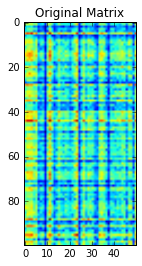

In [11]:
plt.imshow(X)
plt.title('Original Matrix')

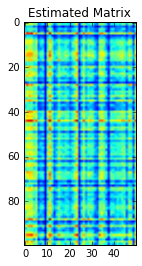

In [12]:
plt.imshow(np.dot(A_hat,S_hat))
plt.title('Estimated Matrix')

#### Group Version 
In this version we keep the dimensions and the group as in the paper. In this case, the groups are stacked matrices $X_l$ one under each other.

In [13]:
# generated some random class labels
labels = np.random.binomial(1,0.5,X.shape[0])

In [14]:
def perGroupNMF(X,k, labels):
    """
        perGroupNMF calculates NMF for each category
        
        Parameters
        ----------
        
        Outputs
        -------
        S_groups - an array containing the bases extracted by NMF for each group
                   the dimension is #groups*k x n
        S_labels - an array of group labels
    """
    
    # Accumulate basis vectors
    S_groups = []
    S_labels = []
    
    # The names of the groups
    groups = np.unique(labels)
    
    for group in groups:
        idx = (labels == group)
        A,S,err = NMF(X[idx,],k)
        S_groups.append(S)
        S_labels.append(group*np.ones((S.shape[0],)))
            
    # convert to numpy array
    S_groups = np.array(S_groups)
    S_groups = S_groups.reshape(len(groups)*k,m)
    S_labels = np.array(S_labels)
    S_labels = S_labels.ravel()
    return(S_groups, S_labels)

Cluster the bases using hierarchical clustering:

In [19]:
S_groups, S_labels = perGroupNMF(X,10, labels)

In [20]:
Z = linkage(S_groups, 'ward')

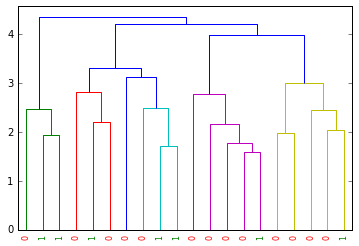

In [21]:
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels = labels,
)

label_colors = {'0': 'r', '1': 'g'}

ax = plt.gca()
xlbls = ax.get_xmajorticklabels()

for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [22]:
# Use the variation of the labels within the cluster to decide which are the common topic (across groups)

In [23]:
def findCommonBases(S_groups, threshold):
    """
        findCommonBases groups the bases into several clusters.
        Then looks at the variation of categories within a cluster.
        The clusters with high variation are expected to contain basis vectors across categories.
        Based on a threshold (which needs to be carefully selected), 
        an index of common bases is returned.
        
        Parameters
        ----------
        
        Outputs
        -------
        common_idx: a boolean array of size equal to the rows of S_groups,
        i. e. the number of basis vectors.
        
    """
    
    Z = linkage(S_groups, 'ward')
    cluster_labels = cut_tree(Z, height = 4).flatten()
    
    # generate an index for bases to remove
    categories = np.unique(cluster_labels)

    labels_clustered = []
    for cat in categories:
        labels_clustered.append(S_labels[cluster_labels == cat])

    
    common_idx = np.zeros(shape = (S_labels.shape[0],),dtype = bool)

    for (cluster,cat) in zip(labels_clustered, categories):
        print(np.var(cluster))
        print(cluster)
        if (np.var(cluster)>threshold):
            common_idx = np.logical_or(common_idx,(cluster_labels == cat))
        
    return(common_idx)
    

In [24]:
common_idx = findCommonBases(S_groups, threshold = 0.24)

0.25
[ 0.  0.  0.  0.  0.  1.  1.  1.  1.  1.]
0.244897959184
[ 0.  0.  0.  1.  1.  1.  1.]
0.222222222222
[ 0.  0.  1.]


In [25]:
# Size of the new matrix of basis vectors
S_groups[common_idx,:].shape

(17, 50)